In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
sys.path.append('../core/')
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from scipy.interpolate import RegularGridInterpolator, splrep, splev, InterpolatedUnivariateSpline, UnivariateSpline
from scipy.stats import chi2, gaussian_kde, norm
from scipy.special import erfinv, erf
import healpy as hp
import gc
gc.enable()
from settings import *

from tqdm import tqdm, trange, tqdm_notebook
fs=20
fs_ticks = 16

from matplotlib.ticker import (AutoMinorLocator, FixedLocator, FuncFormatter,
                               MultipleLocator, NullLocator, LogLocator)
import healpy as hp
from matplotlib.lines import Line2D
from copy import deepcopy

from tools import *
from tools import _trans

In [3]:
c='#DC6C25'

In [4]:

# define location of experiments
poles = {
    'IceCube': {"lon": 1*u.deg, "lat": -90*u.deg, "color": "tab:orange"},
    'P-ONE': {"lon": -123.3656*u.deg, "lat": 48.4284*u.deg, "color": "tab:blue"},
    'KM3NeT': {"lon": (16 + 6/60)*u.deg, "lat": (36 + 16/60)*u.deg, "color": "k"},
    'Baikal-GVD': {"lon": 108.1650*u.deg, "lat": 53.5587*u.deg, "color": "tab:cyan"}
}

### testing cartopy :)

In [5]:
import cartopy.crs as ccrs

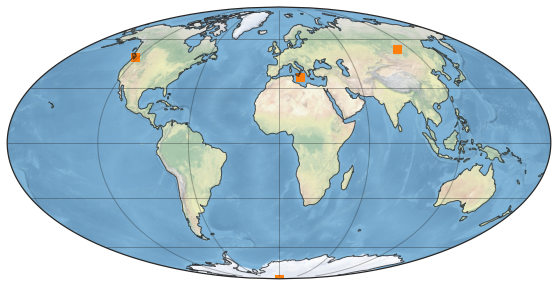

In [6]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=ccrs.Mollweide())
ax.set_global()
ax.stock_img()
ax.coastlines(color="k", alpha=0.7)
gl = ax.gridlines(draw_labels=False, alpha=0.3, color="k", ls=":")


for i, (name, new_pole) in enumerate(sorted(poles.items())):
    ax.scatter(
        np.degrees(new_pole["lon"]), np.degrees(new_pole["lat"]),
        s=70, alpha=1,
        marker='s', c="tab:orange", linestyle='None', 
        label=name,
        transform=ccrs.PlateCarree()
    )

In [7]:
# add fermi sources on top 
_3FHL = np.load('../resources/3FHL_All_2019.npy')
_4FGL = np.load('../resources/4FGL.npy')

In [8]:
tracks = np.load('../resources/tracks.npy')

ang_unc = np.empty(len(tracks), dtype=float)
for i, ra_err in enumerate(tracks['ra_err']):
    name = tracks['name'][i]
    if b'HES' in name and not b'AHES' in name:
        ang_unc[i] = ra_err[0]
    else:
        Dec_err = np.mean([tracks['dec_err'][i][0], -tracks['dec_err'][i][1]])
        Ra_err = np.mean([ra_err[0], -ra_err[1]])
        ang_unc[i] = conv2ang_uncertainty(Ra_err,Dec_err, tracks['dec'][i])

        
tracks = np.lib.recfunctions.append_fields(tracks, names='sigma', data=ang_unc,
                                        dtypes=float, usemask=False)

# Create a skymap including the ps detection efficiency and all HE tracks 

### First, get icecube detection efficiency

In [9]:
with open("../resources/tabulated_logE_sindec_aeff.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = calc_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = calc_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = calc_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

# with two dimensions: sindec, energy
aeff_eval_e_sd = lambda aeff: (aeff * sindec_width).T * ewidth * np.sum(ra_width) # = 2pi

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
print(len(ra_mids), "RA bins")

40 log_10(energy) bins
50 declination bins
100 RA bins


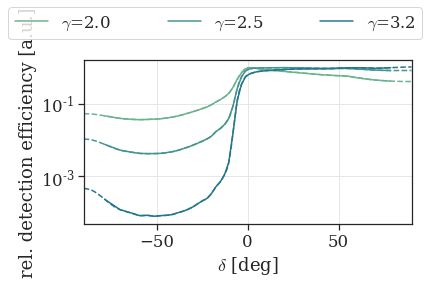

In [10]:
xvals = np.linspace(-1, 1, 1000)

tcks = dict()
gammas = [2.0, 2.5, 3.2]

fig, ax = plt.subplots()
for gamma in gammas:
    Res = np.sum(aeff_eval_e_sd(aeff_2d["IceCube_full"]) * emids**(-gamma), axis=-1) / sindec_width
    Res_max = np.max(Res)
    Res /= np.max(Res)
    tck = splrep(sindec_mids, np.log(Res), s=1.e-3)
    spl_val = np.exp(splev(xvals, tck))
    tcks[gamma] = tck
    p = ax.plot(np.rad2deg(np.arcsin(sindec_mids)), Res, label=r'$\gamma$={0:.1f}'.format(gamma))
    ax.plot(np.rad2deg(np.arcsin(xvals)), spl_val, ls='dashed', color=p[0].get_color())
    
fig.legend(loc='upper center', ncol=3, mode='expand')
ax.set_xlabel(r'$\delta$ [deg]')
ax.set_ylabel(r'rel. detection efficiency [a.u.]', fontsize="medium")
ax.set_yscale('log')
ax.set_xlim(-90, 90)
fig.tight_layout()
plt.subplots_adjust(top = 0.82)

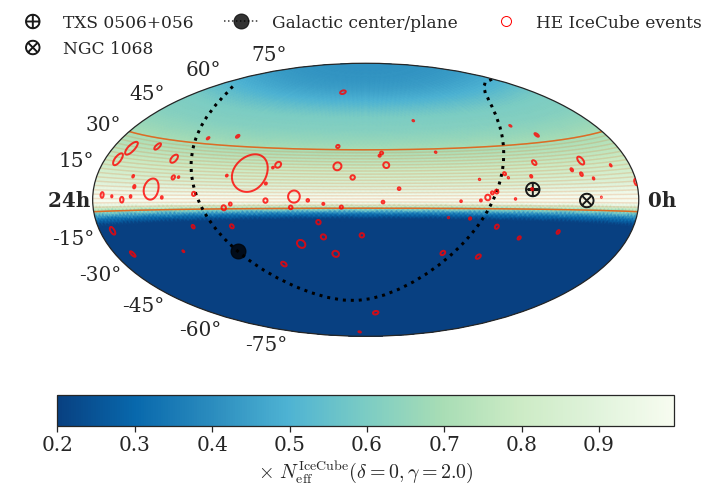

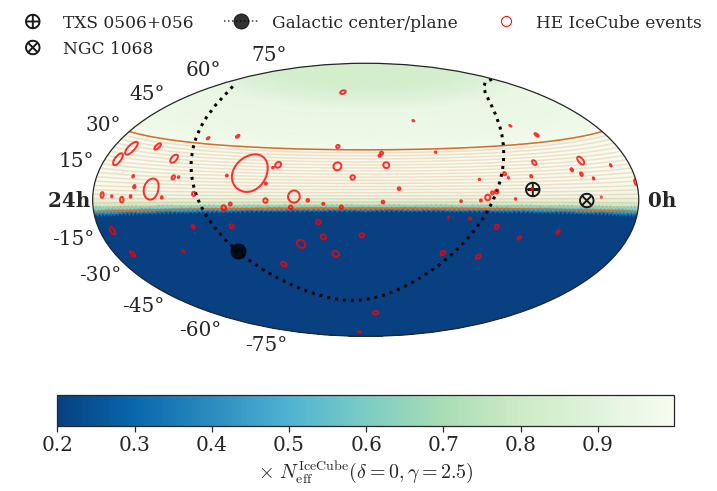

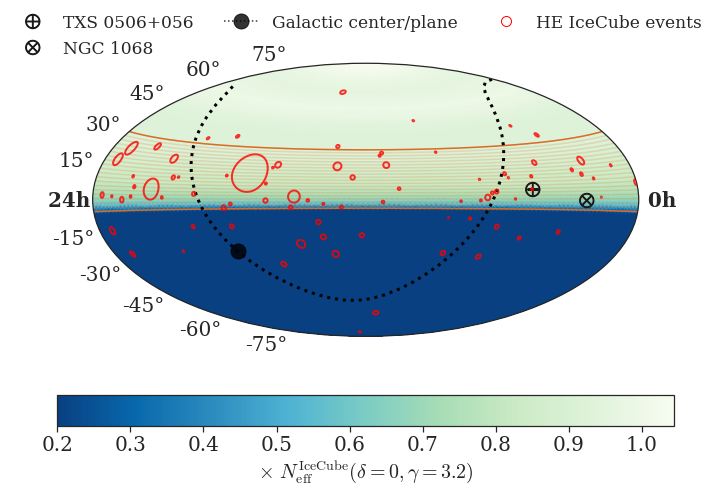

In [11]:
NSIDE = 2**5
npix = hp.nside2npix(NSIDE)



for gamma in gammas:
    num = 5000
    x = np.linspace(0, 2*np.pi, num)
    y = np.linspace(-np.pi/2, np.pi/2, 500)
    cvals = np.zeros(npix)
    for dec_i in y:
        #get the pixels
        p = hp.ang2pix(NSIDE, dec_i + np.pi/2, x)
        #fill them 
        cvals[p] = np.exp(splev(np.sin(dec_i), tcks[gamma]))

    ngrid = 500
    fig = plt.figure(figsize=(10,7.))
    ax= fig.add_subplot(111, projection='hammer', rasterized=True)

    #-------------------------------
    # plot everything
    #-------------------------------

    cax = plot_area(
        cvals, ax, npix=ngrid,  alpha=1., vmin=2.e-1, #vmax=1.,
        shading='gouraud', cmap='GnBu_r')#, norm=LogNorm())

    cbar = fig.colorbar(cax, orientation='horizontal')
    cbar.set_label(
        fr'$\times$ $N_{{\rm eff}}^{{\rm IceCube}}(\delta=0, \gamma={gamma})$', 
        fontsize=fs
    )
    cbar.ax.tick_params(labelsize=fs)

    #---------------------------------------
    # show the IceCube lines between -5 and 30 deg
    #---------------------------------------
    c = '#DC6C25'
    num = 10
    x = np.linspace(0, 2*np.pi, num)
    y1 = np.tile(np.radians(-5.), num)
    y2 = np.tile(np.radians(30), num)

    _x, _y1 =  _trans(x, y1)
    _x, _y2 =  _trans(x, y2)
    ind = np.argsort(_x)
    ax.plot(_x[ind], _y1[ind], color=c)
    ax.plot(_x[ind], _y2[ind], color=c)

    for y_i in np.linspace(-5, 30,num=20, endpoint=True): 
        y2 = np.tile(y_i ,len(x))

        _x2, _y2 = _trans(x, np.radians(y2))
        ind = np.argsort(_x2)
        ax.plot(np.sort(_x2), _y2[ind], color=c, alpha=0.2)

    #loc1, loc2 = _trans(0, -np.pi/2)
    #ax.plot(loc1, loc2, marker='s', c=c, linestyle='None')


    #  add also TXS and NGC1068
    add_obj(ax, "txs", marker=r'$\bigoplus$', c='k') #DC6C25
    add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k') #DC6C25


    # add event with error radius
    for i, (rai, deci, si) in enumerate(zip(tracks['ra'], tracks['dec'], tracks['sigma'])):
        c='red'
        if i == 0:
            res = add_event(
                ax, ra_i=np.radians(rai), dec_i=np.radians(deci), sigma_i=np.radians(si),
                labels=['IceCube HE events'], color=c, linewidths=2., zorder=10
            )
        else:
            add_event(
                ax, ra_i=np.radians(rai), dec_i=np.radians(deci), sigma_i=np.radians(si),
                color=c, linewidths=2.,zorder=10
            )

    # fix the labels
    set_ticks(ax, fs=fs)
    # add the galactic center and plane
    add_plane(ax, color='black')

    #get all legend entries and add the circle for the HE events
    handles, labels = ax.get_legend_handles_labels()
    HE_events = Line2D(
        range(1), range(1), color="red", 
        marker='o', markersize=10, markerfacecolor="None",
        linewidth=0, label='HE IceCube events'
    )
    handles.append(HE_events)
    fig.legend(
        handles=handles, fontsize=fs-3,
        #loc=0, 
        mode='expand',
        ncol=3, frameon=False
    )

    fig.tight_layout()
    plt.subplots_adjust(top = 0.87) #, bottom=0.2)
    fig.savefig(
        f'../plots/IceCube_Skymap_horizon_gamma{int(np.round(gamma*10))}.pdf',
        bbox_inches="tight", dpi=200)
    plt.show()

# Show a skymap with 4 time snippets of the cumulative view of the best field 
# of view of all existing telescopes

### IceCube only, all day, every day 

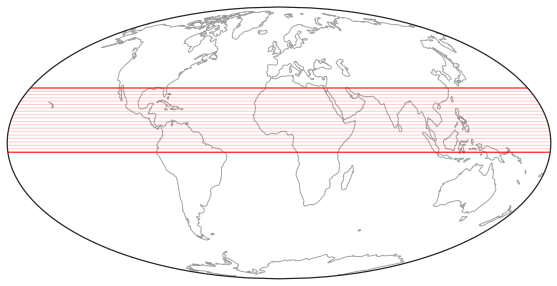

In [12]:
num = 2000
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines(color="gray", alpha=0.7)
x = np.linspace(0, 2*np.pi, num)
y1 = np.tile(np.radians(-5.), num)
y2 = np.tile(np.radians(30), num)

ax.plot(np.rad2deg(x), np.rad2deg(y1), color=c, transform=ccrs.PlateCarree(), lw=1)
ax.plot(np.rad2deg(x), np.rad2deg(y2), color=c, transform=ccrs.PlateCarree(), lw=1)

for y_i in np.linspace(-5, 30, num=20, endpoint=True):
    y_loc = np.tile(y_i, len(x))
    ax.plot(np.rad2deg(x), y_loc, color=c, alpha=0.2, transform=ccrs.PlateCarree(), lw=1)

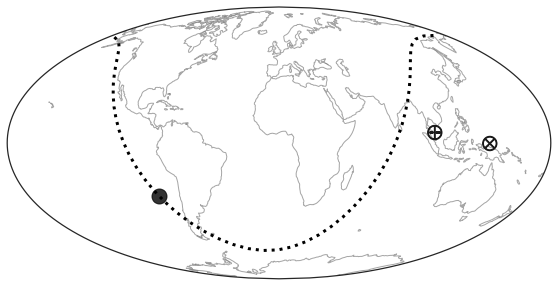

In [107]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines(color="gray", alpha=0.7)
add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', transform=ccrs.PlateCarree()) #DC6C25
add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', transform=ccrs.PlateCarree()) #DC6C25
add_plane(ax, color='black', transform=ccrs.PlateCarree())

IceCube
P-ONE
KM3NeT
Baikal-GVD


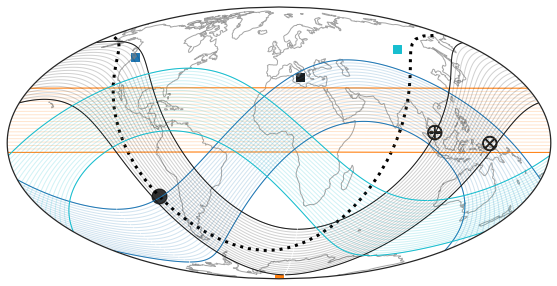

IceCube
P-ONE
KM3NeT
Baikal-GVD


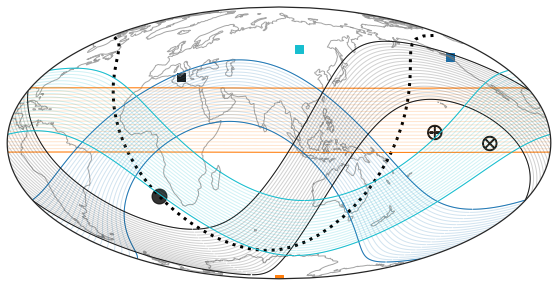

IceCube
P-ONE
KM3NeT
Baikal-GVD


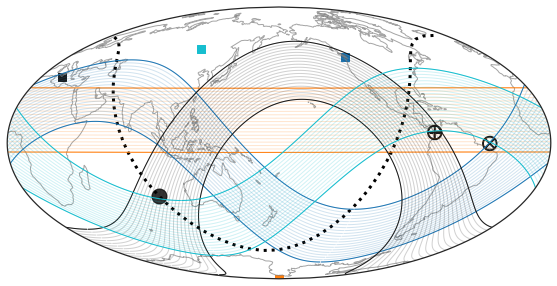

IceCube
P-ONE
KM3NeT
Baikal-GVD


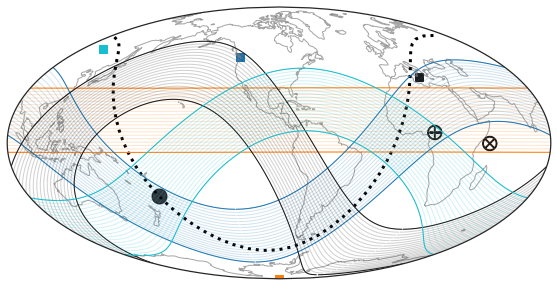

In [116]:
for clon in [0, 90, 180, 270]:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(projection=ccrs.Mollweide(central_longitude=clon))
    ax.set_global()
    ax.coastlines(color="gray", alpha=0.7)
    num = 500
    x = np.linspace(0, 360, num)
    y1 = np.tile(5., num)
    y2 = np.tile(-30, num)

    # coordinate grid in equatorial coordinates (icrs)
    # these will be the integration coordinates
    eq_coords_low = SkyCoord(
        x * u.degree,
        y1 * u.degree,
        frame="icrs"
    )
    eq_coords_up = SkyCoord(
        x * u.degree,
        y2 * u.degree,
        frame="icrs"
    )

    ic_loc = EarthLocation(
        lat=poles["IceCube"]["lat"],
        lon=poles["IceCube"]["lon"],
    )

    add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', transform=ccrs.PlateCarree(central_longitude=clon)) #DC6C25
    add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', transform=ccrs.PlateCarree(central_longitude=clon)) #DC6C25
    add_plane(ax, color='black', transform=ccrs.PlateCarree(central_longitude=clon))

    # loop over detectors
    for i, (k, coord) in enumerate(poles.items()):
        print(k)
        # local detector
        loc = EarthLocation(
            lat=coord["lat"],
            lon=coord["lon"],
        )
        time = Time('2021-4-20 00:00:00', scale="utc")
        # transform integration coordinates to local frame
        local_coords_low = eq_coords_low.transform_to(AltAz(obstime=time, location=loc))
        local_coords_up = eq_coords_up.transform_to(AltAz(obstime=time, location=loc))
        
        ind = np.argsort(local_coords_low.az.deg)
        ax.plot(local_coords_low.az.deg[ind] + loc.lon.deg, local_coords_low.alt.deg[ind], transform=ccrs.PlateCarree(), lw=1, color=coord["color"])
        ax.plot(local_coords_up.az.deg[ind] + loc.lon.deg, local_coords_up.alt.deg[ind], transform=ccrs.PlateCarree(), lw=1, color=coord["color"])
        ax.scatter(loc.lon.deg, loc.lat.deg, color=coord["color"], marker="s", s=50, transform=ccrs.PlateCarree())

        for y_i in np.linspace(-30, 5, num=20, endpoint=True):
            y_loc = np.tile(y_i, len(x))
            local_coords_tmp = SkyCoord(
                x * u.degree, y_loc * u.degree, frame="icrs"
            ).transform_to(AltAz(obstime=time, location=loc))
            ind = np.argsort(local_coords_tmp.az.deg)
            ax.plot(
                local_coords_tmp.az[ind].deg + loc.lon.deg, 
                local_coords_tmp.alt.deg[ind], 
                transform=ccrs.PlateCarree(), 
                lw=1, color=coord["color"], 
                alpha=0.2
            )
    plt.show()

#### fixed until here --

# Get the detection eiffiency from each telescope for one time stamp

In [ ]:
poles = {'IceCube':(np.radians(0), np.radians(-90.)),
         'P-ONE':(-np.radians(123.3656), np.radians(48.4284)),
         'KM3NeT':(np.radians(16.1), np.radians(36.27)) ,
         'Baikal-GVD':(np.radians(108.1650), np.radians(53.5587)),
         #'SA, Cape Town ':(np.radians(18.4241), np.radians(-33.9249)),
        #'hypothetical':(np.radians(0.2093), np.radians(-0.8688)),
        }
      
values = dict()

for i,(name, new_pole) in enumerate(sorted(poles.iteritems())):    
    
    vals = np.zeros(npix)    
    rot_angles = np.arange(0.,10., 15.)
    for rot_ra in tqdm(rot_angles):
        vals2 = np.zeros(npix)
        new_ra = new_pole[0] + np.radians(rot_ra)
        
        x = np.linspace(0,2*np.pi, 1.e3)
        y = np.linspace(-np.pi/2,np.pi/2 ,500)
    
        xx, yy = np.meshgrid(x,y,indexing='ij')
        
        ra2 , dec2 = rotate(0, -np.pi/2, new_ra, new_pole[1],xx.ravel(),yy.ravel())
        
        
        lat2 = np.pi/2 + dec2
        lat2 = lat2
        lon2, lat2 = _trans(ra2, lat2)
        
        p = hp.ang2pix(NSIDE, lat2, lon2)
        vals2[p] = np.exp(splev(yy.ravel(), tck))
    
        vals = vals + vals2 * (1. / len(rot_angles))
    
    values[name] = vals

In [ ]:
fig =  plt.figure(figsize=(16,10))


n2ind = {'IceCube':221, 'P-ONE':222, 'KM3NeT':223, 'Baikal-GVD':224}
for i, (name, vals) in enumerate(values.iteritems()):

    ax = fig.add_subplot(n2ind[name], projection='hammer',
                                       rasterized=True)

    cax=plot_area(vals, ax, npix=ngrid,  alpha=1., vmin=0., vmax=1.,
             shading='gouraud', cmap='GnBu_r')#, norm=LogNorm())

    
    #-------------------------------
    # 3FHL 
    #-------------------------------
    c='red'
    '''
    if i==0:
        add_catalog(ax, cat=_3FHL, n=100, label='3FHL sources', marker='o',  s=15,
           alpha=0.,  vals=vals)
    else:
        add_catalog(ax, cat=_3FHL, n=100, label='__None__', marker='o',  s=15,
           alpha=0.,  vals=vals)
    #-------------------------------
    # 4FGL
    #-------------------------------
    
    if i ==0:
        add_catalog(ax, cat=_4FGL, n=100, label='4FGL sources', marker='s', color=c,s=15,
              alpha=0.8, vals=vals)
    else:
        add_catalog(ax, cat=_4FGL, n=100, label='__None__', marker='s', color=c,s=15,
              alpha=0.8, vals=vals)
    '''
    #-------------------------------
    # fix the labels
    #-------------------------------

    set_ticks(ax, fs=fs)
    

    #---------------------------------------
    # add the galactic center and plane
    #---------------------------------------

    if i==0:
        add_plane(ax, color='black')
    else:
        add_plane(ax, color='black', label='__None__')

    #---------------------------------------
    #  add also TXS
    #---------------------------------------
    if i==0:
        add_txs(ax, marker='o' ,c='#DC6C25')
    else:
        add_txs(ax, marker='o' ,c='#DC6C25', label='__None__')
  

    ax.text(0.73,0.97, name, fontsize=30 ,
                 transform = ax.transAxes)

    

fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False,  mode='expand')

fig.tight_layout()
cbar_ax = fig.add_axes([0.95, 0.05, 0.02, 0.85])
cbar = fig.colorbar(cax, cax=cbar_ax)# , orientation='vertical')                  
cbar.set_label(r'$\times$ $N_{\mathrm{eff}}^{\mathrm{IceCube}}(\delta=0, \gamma=2)$', fontsize=fs)
cbar.ax.tick_params(labelsize=fs+2)


plt.subplots_adjust(top = 0.9, right=0.9, wspace=0.15)
'''
if len(rot_angles) ==1:
    fig.savefig('plots/Plenum_DetEff1.png',
                bbox_inches="tight", dpi=200)    
else:
    fig.savefig('plots/Plenum_DetEff_integrated.png',
                bbox_inches="tight", dpi=200)
'''

---
# Plenum improvements for gamma=2 and the same amount of time

---

In [ ]:
fact = 1.
poles = {'IceCube':(np.radians(0), np.radians(-90.)),
         'Gen2':(np.radians(0), np.radians(-90.)),
         'P-ONE':(-np.radians(123.3656), np.radians(48.4284)),
         'KM3NeT':(np.radians(16.1), np.radians(36.27)) ,
         'Baikal-GVD':(np.radians(108.1650), np.radians(53.5587)),
         #'X, China':(np.radians(111.918), np.radians(8.640)),
         #'SA, Cape Town ':(np.radians(18.4241), np.radians(-33.9249)),
        #'hypothetical':(np.radians(0.2093), np.radians(-0.8688)),
        }
      
comb_values = dict()

    
for i,(name, new_pole) in enumerate(sorted(poles.iteritems())):    
    
    vals = np.zeros(npix)    
    rot_angles = np.arange(0.,360., 15.) #15.
    for rot_ra in tqdm(rot_angles):
        vals2 = np.zeros(npix)
        new_ra = new_pole[0] + np.radians(rot_ra)
        
        x = np.linspace(0,2*np.pi, 1.e3)
        y = np.linspace(-np.pi/2,np.pi/2 ,500)
    
        xx, yy = np.meshgrid(x,y,indexing='ij')
        
        ra2 , dec2 = rotate(0, -np.pi/2, new_ra, new_pole[1],xx.ravel(),yy.ravel())
        
        
        lat2 = np.pi/2 + dec2
        lat2 = lat2
        lon2, lat2 = _trans(ra2, lat2)
        
        p = hp.ang2pix(NSIDE, lat2, lon2)
        
        if name == 'IceCube' or 'Gen2' in name:
            vals2[p] = np.exp(splev(yy.ravel(), tck))
        else:
            vals2[p] = np.exp(splev(yy.ravel(), tck))
        
        if name == 'Gen2':
            vals2 *= 7.5
    
        vals = vals + vals2 * (1. / len(rot_angles))
    
    comb_values[name] = vals
    
blub = 5000

This plot shows a direct comparison of plenum and IceCube for equal run times

In [ ]:
t_0 = 0. # years
t_new = 1. # years

used_keys = list()
fact = 1.

fig =  plt.figure(figsize=(16,6))
    
bckg_vals2 = deepcopy(comb_values['IceCube'])
all_vals = deepcopy(comb_values)


i2ind = {0:121, 1:122}

variation = ['r0', 'rrel']
labels = {'r0': r'R$_0$', 'rrel':r'R$_{\mathrm{rel}}$'}
extreme = {'r0': (0.7,2.2), 'rrel':(2,25.)}
for i, vari in enumerate(variation):
    
    comb_vals = np.zeros(npix)
    ax= fig.add_subplot(i2ind[i], projection='hammer',
                                       rasterized=True)
    
    for (name, vali) in sorted(all_vals.iteritems()):
        if vari == 'rrel':
            mask_bckg = bckg_vals2 > 0.0
            vali[mask_bckg] /= bckg_vals2[mask_bckg]
            vali[~mask_bckg] = np.max(vali[mask_bckg])
            
    
        nuse = [ 'X, China',#'P-ONE','KM3NeT'
                         ]
        

        if name == 'IceCube' and 'Gen2' in nuse:
            comb_vals += (t_0+t_new) * vali
        elif name == 'IceCube':
            comb_vals += t_0 * vali
        elif name in nuse:
            continue
        else:
            comb_vals += t_new * vali * fact

        if name not in used_keys:
            used_keys.append(name)

    new_vals = (comb_vals / (t_0+t_new))**(-0.8)
    mask0 = new_vals > 0.
    new_vals[mask0] = 1. / new_vals[mask0]
    new_vals[~mask0] = 0.

    print(np.min(new_vals))

    #
    #
    _min,_max = extreme[vari]
    _min = np.min(new_vals)
    _max = np.max(new_vals)
    
    print(_max)

    cax=plot_area(new_vals, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
             shading='gouraud', cmap='GnBu_r', norm=LogNorm())

    cbar = fig.colorbar(cax,  orientation='horizontal')
    cbar.ax.tick_params(labelsize=fs)
    cbar.set_label(labels[vari], 
                   fontsize=fs)

    '''
    cb_marker0 = (np.log10(np.max(new_vals))- np.log10(_min))  / (- np.log10(_min)+np.log10(_max))
    cbar.ax.plot([cb_marker0]*2, [0, 1], 'red')

    cb_marker1 = (np.log10(np.min(new_vals))- np.log10(_min))  / (- np.log10(_min)+np.log10(_max))
    cbar.ax.plot([cb_marker1]*2, [0, 1], 'red')

    cbar.ax.fill_between([cb_marker1,cb_marker0], [0,0],[1,1], color='red', alpha=0.2)
    '''

    

    #-------------------------------
    # 3FHL 
    #-------------------------------
    c='red'
    '''
    if i==0:
        add_catalog(ax, cat=_3FHL, n=100, label='3FHL sources', marker='o', color=c, s=15,
           alpha=0.,  vals=vals)
    else:
        add_catalog(ax, cat=_3FHL, n=100, label='__None__', marker='o', color=c, s=15,
           alpha=0.,  vals=vals)
    #-------------------------------
    # 4FGL
    #-------------------------------
    
    if i ==0:
        add_catalog(ax, cat=_4FGL, n=100, label='4FGL sources', marker='s', color=c,s=15,
              alpha=0.8, vals=vals)
    else:
        add_catalog(ax, cat=_4FGL, n=100, label='__None__', marker='s', color=c,s=15,
              alpha=0.8, vals=vals)
    '''
    #-------------------------------
    # fix the labels
    #-------------------------------

    set_ticks(ax, fs=fs)
    

    #---------------------------------------
    # add the galactic center and plane
    #---------------------------------------

    if i==0:
        add_plane(ax, color='black')
    else:
        add_plane(ax, color='black', label='__None__')

    #---------------------------------------
    #  add also TXS
    #---------------------------------------
    if i==0:
        add_txs(ax, marker='o' ,c='#DC6C25')
    else:
        add_txs(ax, marker='o' ,c='#DC6C25', label='__None__')
  

    


    ax.text(.9, .01, r"$\gamma=3.2$", ha='left', size=fs+10, transform=ax.transAxes,
           color='red')
    

fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False,  mode='expand')
fig.tight_layout()

plt.subplots_adjust(top = 0.84)#, bottom=0.2)
   
fig.savefig('plots/Plenum_g3_2.png',
                bbox_inches="tight", dpi=200)


In [ ]:
print used_keys

# Redo this plot for gamma =1.5 and 2.5 as well

In [ ]:
fact = 1.
poles = {'IceCube':(np.radians(0), np.radians(-90.)),
         #'Gen2':(np.radians(0), np.radians(-90.)),
         'P-ONE':(-np.radians(123.3656), np.radians(48.4284)),
         'KM3NeT':(np.radians(16.1), np.radians(36.27)) ,
         'Baikal-GVD':(np.radians(108.1650), np.radians(53.5587)),
         #'X, China':(np.radians(111.918), np.radians(8.640)),
         #'SA, Cape Town ':(np.radians(18.4241), np.radians(-33.9249)),
        #'hypothetical':(np.radians(0.2093), np.radians(-0.8688)),
        }
      
Comb_values = dict()

for gi, tcki in tcks.iteritems():    
    comb_vals = dict()
    for i,(name, new_pole) in enumerate(sorted(poles.iteritems())):    

        vals = np.zeros(npix)    
        rot_angles = np.arange(0.,360., 15.) #15.
        for rot_ra in tqdm(rot_angles):
            vals2 = np.zeros(npix)
            new_ra = new_pole[0] + np.radians(rot_ra)

            x = np.linspace(0,2*np.pi, 1.e3)
            y = np.linspace(-np.pi/2,np.pi/2 ,500)

            xx, yy = np.meshgrid(x,y,indexing='ij')

            ra2 , dec2 = rotate_new(0, -np.pi/2, new_ra, new_pole[1],xx.ravel(),yy.ravel())


            lat2 = np.pi/2 + dec2
            lat2 = lat2
            lon2, lat2 = _trans(ra2, lat2)

            p = hp.ang2pix(NSIDE, lat2, lon2)

            if name == 'IceCube' or 'Gen2' in name:
                vals2[p] = np.exp(splev(yy.ravel(), tcki))
            else:
                vals2[p] = np.exp(splev(yy.ravel(), tcki)) 

            if name == 'Gen2':
                vals2 *= 7.5

            vals = vals + vals2 * (1. / len(rot_angles))

        comb_vals[name] = vals
        
    Comb_values[gi] = comb_vals

blub = 5000

In [ ]:
t_0 = 0. # years
t_new = 1. # years

used_keys = list()
fact = 1.

fig =  plt.figure(figsize=(16,12))
    
variation = ['r0', 'rrel']
labels = {'r0': r'R$_0$', 'rrel':r'R$_{\mathrm{rel}}$'}
extreme = {'r0': (0.7,2.2), 'rrel':(2,25.)}
gi2ind = {(1.5, 0):221, (1.5,1):222,(2.5, 0):223, (2.5,1):224 }


for gi, comb_valuesi in sorted(Comb_values.iteritems()):
    if gi==2:
        continue
        
    bckg_vals2 = deepcopy(comb_valuesi['IceCube'])
    all_vals = deepcopy(comb_valuesi)


    for i, vari in enumerate(variation):

        comb_vals = np.zeros(npix)
        ax= fig.add_subplot(gi2ind[(gi,i)], projection='hammer',
                                           rasterized=True)

        for (name, vali) in sorted(all_vals.iteritems()):
            if vari == 'rrel':
                mask_bckg = bckg_vals2 > 0.0
                vali[mask_bckg] /= bckg_vals2[mask_bckg]
                vali[~mask_bckg] = np.max(vali[mask_bckg])


            nuse = [ 'Gen2',  'P-ONE',  'KM3NeT']


            if name == 'IceCube' and 'Gen2' in nuse:
                comb_vals += (t_0+t_new) * vali
            elif name == 'IceCube':
                comb_vals += t_0 * vali
            elif name in nuse:
                continue
            else:
                comb_vals += t_new * vali * fact

            if name not in used_keys:
                used_keys.append(name)

        new_vals = (comb_vals / (t_0+t_new))**(-0.8)
        mask0 = new_vals > 0.
        new_vals[mask0] = 1. / new_vals[mask0]
        new_vals[~mask0] = 0.

        
        print(gi, np.max(new_vals))
        _min,_max = extreme[vari]
        _min = np.min(new_vals)
        _max = np.max(new_vals)


        cax=plot_area(new_vals, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
                 shading='gouraud', cmap='GnBu_r')#, norm=LogNorm())

        cbar = fig.colorbar(cax,  orientation='horizontal')
        cbar.ax.tick_params(labelsize=fs)
        cbar.set_label(labels[vari], 
                       fontsize=fs)

        '''
        cb_marker0 = (np.log10(np.max(new_vals))- np.log10(_min))  / (- np.log10(_min)+np.log10(_max))
        cbar.ax.plot([cb_marker0]*2, [0, 1], 'red')

        cb_marker1 = (np.log10(np.min(new_vals))- np.log10(_min))  / (- np.log10(_min)+np.log10(_max))
        cbar.ax.plot([cb_marker1]*2, [0, 1], 'red')

        cbar.ax.fill_between([cb_marker1,cb_marker0], [0,0],[1,1], color='red', alpha=0.2)
        '''



        #-------------------------------
        # 3FHL 
        #-------------------------------
        c='red'
        if i==0 and gi==1.5:
            add_catalog(ax, cat=_3FHL, n=100, label='3FHL sources', marker='o', color=c, s=15,
               alpha=0.,  vals=vals)
        else:
            add_catalog(ax, cat=_3FHL, n=100, label='__None__', marker='o', color=c, s=15,
               alpha=0.,  vals=vals)
        #-------------------------------
        # 4FGL
        #-------------------------------

        if i==0 and gi==1.5:
            add_catalog(ax, cat=_4FGL, n=100, label='4FGL sources', marker='s', color=c,s=15,
                  alpha=0.8, vals=vals)
        else:
            add_catalog(ax, cat=_4FGL, n=100, label='__None__', marker='s', color=c,s=15,
                  alpha=0.8, vals=vals)

        #-------------------------------
        # fix the labels
        #-------------------------------

        set_ticks(ax, fs=fs)


        #---------------------------------------
        # add the galactic center and plane
        #---------------------------------------

        if i==0 and gi==1.5:
            add_plane(ax, color='black')
        else:
            add_plane(ax, color='black', label='__None__')

        #---------------------------------------
        #  add also TXS
        #---------------------------------------
        if i==0 and gi==1.5:
            add_txs(ax, marker='o' ,c='#DC6C25')
        else:
            add_txs(ax, marker='o' ,c='#DC6C25', label='__None__')





        ax.text(.85, .01, r"$\gamma={0:.1f}$".format(gi), ha='left', size=fs+10, transform=ax.transAxes,
               color='red')
    

fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False,  mode='expand')
fig.tight_layout()

plt.subplots_adjust(top = 0.9)#, bottom=0.2)
   

#fig.savefig('plots/Plenum_g15_25.png',
#                bbox_inches="tight", dpi=200)
#fig.savefig('plots/IceCube_gvd_g15_25.png',
#                bbox_inches="tight", dpi=200)




----

# Show the time evolution of plenum

----

This plot will show how plenum improves (after x years) the total discovery potential if we turn it on after 10years of IceCube 

In [ ]:
t_0 = 10. # years
t_news = [1.,3.,5.,10.] # years

used_keys = list()
fact = 1.

fig =  plt.figure(figsize=(16,12))
    
variation = ['r0', 'rrel']
labels = {'r0': r'R$_0$', 'rrel':r'R$_{\mathrm{rel}}$'}
extreme = {'r0': (0.7,2.2), 'rrel':(2,25.)}
i2ind = { 0:221, 1:222,2:223, 3:224 }
vari = 'rrel'

        
for i, t_new in enumerate(t_news):
    
    all_vals = deepcopy(comb_values)
    bckg_vals2 = deepcopy(comb_values['IceCube'])
    
    comb_vals = np.zeros(npix)
    ax= fig.add_subplot(i2ind[i], projection='hammer',
                                       rasterized=True)

    for (name, vali) in sorted(all_vals.iteritems()):
        
        mask_bckg = bckg_vals2 > 0.0
        vali[mask_bckg] /= bckg_vals2[mask_bckg]
        vali[~mask_bckg] = np.max(vali[mask_bckg])


        nuse = ['X, China', 'Gen2']


        if name == 'IceCube' and 'Gen2' in nuse:
            comb_vals += (t_0+t_new) * vali
        elif name == 'IceCube':
            comb_vals += t_0 * vali
        elif name in nuse:
            continue
        else:
            comb_vals += t_new * vali * fact

        if name not in used_keys:
            used_keys.append(name)

    new_vals = (comb_vals / (t_0+t_new))**(-0.8)
    mask0 = new_vals > 0.
    new_vals[mask0] = 1. / new_vals[mask0]
    new_vals[~mask0] = 0.


    
    _min = 1.#np.min(new_vals)
    _max = 14.
    print(np.min(new_vals), np.max(new_vals))

    #new_vals[new_vals<1.7] = 0
    cax=plot_area(new_vals, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
             shading='gouraud', cmap='GnBu_r')#, norm=LogNorm())

    cbar = fig.colorbar(cax,  orientation='horizontal')
    cbar.ax.tick_params(labelsize=fs)
    cbar.set_label(labels[vari], 
                   fontsize=fs)

    
    #cb_marker0 = (np.log10(np.max(new_vals))- np.log10(_min))  / (- np.log10(_min)+np.log10(_max))
    cb_marker0 = (np.max(new_vals)- _min)  / (-_min+_max)
    cbar.ax.plot([cb_marker0]*2, [0, 1], 'red')

    #cb_marker1 = (np.log10(np.min(new_vals))- np.log10(_min))  / (- np.log10(_min)+np.log10(_max))
    cb_marker1 = (np.min(new_vals)- _min)  / (- _min+_max)
    cbar.ax.plot([cb_marker1]*2, [0, 1], 'red')

    cbar.ax.fill_between([cb_marker1,cb_marker0], [0,0],[1,1], color='red', alpha=0.2)
    



    #-------------------------------
    # 3FHL 
    #-------------------------------
    c='red'
    if i==0:
        add_catalog(ax, cat=_3FHL, n=100, label='3FHL sources', marker='o', color=c, s=15,
           alpha=0.,  vals=vals)
    else:
        add_catalog(ax, cat=_3FHL, n=100, label='__None__', marker='o', color=c, s=15,
           alpha=0.,  vals=vals)
    #-------------------------------
    # 4FGL
    #-------------------------------

    if i==0:
        add_catalog(ax, cat=_4FGL, n=100, label='4FGL sources', marker='s', color=c,s=15,
              alpha=0.8, vals=vals)
    else:
        add_catalog(ax, cat=_4FGL, n=100, label='__None__', marker='s', color=c,s=15,
              alpha=0.8, vals=vals)

    #-------------------------------
    # fix the labels
    #-------------------------------

    set_ticks(ax, fs=fs)


    #---------------------------------------
    # add the galactic center and plane
    #---------------------------------------

    if i==0:
        add_plane(ax, color='black')
    else:
        add_plane(ax, color='black', label='__None__')

    #---------------------------------------
    #  add also TXS
    #---------------------------------------
    if i==0:
        add_txs(ax, marker='o' ,c='#DC6C25')
    else:
        add_txs(ax, marker='o' ,c='#DC6C25', label='__None__')



    ax.text(.9, .0, r"({1:d}+{0:d})y".format(int(t_new), int(t_0)), ha='left', size=fs+6, transform=ax.transAxes,
       color='red')


fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False,  mode='expand')
fig.tight_layout()

plt.subplots_adjust(top = 0.9)#, bottom=0.2)
   

#fig.savefig('plots/Plenum_evolution.png',
#                bbox_inches="tight", dpi=200)

# Similar plot but now also include Gen2

In [ ]:
t_0 = 10. # years
t_new = 10. # years

used_keys = list()
fact = 1.

fig =  plt.figure(figsize=(16,6))
    
bckg_vals2 = deepcopy(comb_values['IceCube'])
all_vals = deepcopy(comb_values)



labels = {'r0': r'R$_0$', 'rrel':r'R$_{\mathrm{rel}}$'}
vari = 'rrel'

#-------------------------------------------    
# Show the improvements with Gen2 as well   
#-------------------------------------------

comb_vals = np.zeros(npix)
ax= fig.add_subplot(121, projection='hammer',
                                       rasterized=True)
    
for (name, vali) in sorted(all_vals.iteritems()):
    if vari == 'rrel':
        mask_bckg = bckg_vals2 > 0.0
        vali[mask_bckg] /= bckg_vals2[mask_bckg]
        vali[~mask_bckg] = np.max(vali[mask_bckg])


    nuse = ['X, China']


    if name == 'IceCube' and 'Gen2' in nuse:
        comb_vals += (t_0+t_new) * vali
    elif name == 'IceCube':
        comb_vals += t_0 * vali
    elif name in nuse:
        continue
    else:
        comb_vals += t_new * vali * fact

    if name not in used_keys:
        used_keys.append(name)


new_vals = (comb_vals / (t_0+t_new))**(-0.8)
mask0 = new_vals > 0.
new_vals[mask0] = 1. / new_vals[mask0]
new_vals[~mask0] = 0.

_min = np.min(new_vals)
_max = np.max(new_vals)

cax=plot_area(new_vals, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
         shading='gouraud', cmap='GnBu_r')#, norm=LogNorm())

cbar = fig.colorbar(cax,  orientation='horizontal')
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'$R_{\mathrm{rel}}$(PLE$\nu$M+Gen-2 / IceCube)', 
               fontsize=fs)

#-------------------------------
# 3FHL 
#-------------------------------
c='red'

add_catalog(ax, cat=_3FHL, n=100, label='3FHL sources', marker='o', color=c, s=15,
       alpha=0.,  vals=vals)

#-------------------------------
# 4FGL
#-------------------------------
add_catalog(ax, cat=_4FGL, n=100, label='4FGL sources', marker='s', color=c,s=15,
          alpha=0.8, vals=vals)

#-------------------------------
# fix the labels
#-------------------------------

set_ticks(ax, fs=fs)


#---------------------------------------
# add the galactic center and plane
#---------------------------------------
add_plane(ax, color='black')


#---------------------------------------
#  add also TXS
#---------------------------------------
add_txs(ax, marker='o' ,c='#DC6C25')


ax.text(.9, .0, r"({1:d}+{0:d})y".format(int(t_new), int(t_0)), ha='left', size=fs+6, transform=ax.transAxes,
       color='red')






#-------------------------------------------    
# Show the improvements with Gen2 as well   
#-------------------------------------------
bckg_vals2 = deepcopy(comb_values['IceCube'])
all_vals = deepcopy(comb_values)

used_keys2 = list()
comb_vals2 = np.zeros(npix)
ax= fig.add_subplot(122, projection='hammer',
                                       rasterized=True)
    
for (name, vali) in sorted(all_vals.iteritems()):
    if vari == 'rrel':
        mask_bckg = bckg_vals2 > 0.0
        vali[mask_bckg] /= bckg_vals2[mask_bckg]
        vali[~mask_bckg] = np.max(vali[mask_bckg])


    nuse = ['X, China', 'KM3NeT', 'Baikal-GVD', 'P-ONE']


    if name == 'IceCube' and 'Gen2' in nuse:
        comb_vals2 += (t_0+t_new) * vali
    elif name == 'IceCube':
        comb_vals2 += t_0 * vali
    elif name in nuse:
        continue
    else:
        comb_vals2 += t_new * vali * fact

    if name not in used_keys2:
        used_keys2.append(name)

new_vals2 = (comb_vals2 / (t_0+t_new))**(-0.8)
mask0 = new_vals2 > 0.
new_vals2[mask0] = 1. / new_vals2[mask0]
new_vals2[~mask0] = 0.

rvals = new_vals / new_vals2

_min = np.min(rvals)
_max = np.max(rvals)

print(_min, _max)
cax=plot_area(rvals, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
         shading='gouraud', cmap='GnBu_r')#, norm=LogNorm())

cbar = fig.colorbar(cax,  orientation='horizontal')
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'$R_{\mathrm{rel}}$(PLE$\nu$M+Gen-2 / IceCube+Gen-2)', 
               fontsize=fs)

#-------------------------------
# 3FHL 
#-------------------------------
c='red'

add_catalog(ax, cat=_3FHL, n=100, label='__None__', marker='o', color=c, s=15,
       alpha=0.,  vals=vals)

#-------------------------------
# 4FGL
#-------------------------------
add_catalog(ax, cat=_4FGL, n=100, label='__None__', marker='s', color=c,s=15,
          alpha=0.8, vals=vals)

#-------------------------------
# fix the labels
#-------------------------------

set_ticks(ax, fs=fs)


#---------------------------------------
# add the galactic center and plane
#---------------------------------------
add_plane(ax, color='black', label='__None__')


#---------------------------------------
#  add also TXS
#---------------------------------------
add_txs(ax, marker='o' ,c='#DC6C25', label='__None__')


ax.text(.9, .0, r"({1:d}+{0:d})y".format(int(t_new), int(t_0)), ha='left', size=fs+6, transform=ax.transAxes,
       color='red')





fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False,  mode='expand')
fig.tight_layout()

plt.subplots_adjust(top = 0.84)#, bottom=0.2)
   

#fig.savefig('plots/Plenum_Gen2.png',
#                bbox_inches="tight", dpi=200)



In [ ]:
print used_keys, used_keys2

# Ultimately show the discovery potential for PLENUM + GEN2 after 10years

## first load the current discovery potentials of icecube 

In [ ]:
disc = np.genfromtxt('resources/PSdiscPot7years.csv', delimiter=',')
sdec = disc[:,0]
disc = disc[:,1]


#disc /= disc.min()


tck_disc = splrep(sdec, np.log(disc), s=1.e-3)
xvals = np.linspace(-1, 1, 1000)
spl_disc = splev(xvals, tck_disc)

fig,ax=plt.subplots()

ax.plot(xvals,np.exp(spl_disc), color='red', ls='dashed')
ax.plot(sdec, disc, alpha=0.5)
    
fig.legend()
ax.set_xlabel(r'$\sin(\delta)$',fontsize=12)
ax.set_ylabel(r'disc pot [TeV cm$^{-2}$ s$^{-1}$]',fontsize=12)
ax.set_yscale('log')


ps_disc = np.genfromtxt('resources/'+
                        'tcarver_10y_disc.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', color=colors[0],lw=3,
       label='2')


ps_disc = np.genfromtxt('resources/'+
                        '10yr_ps_dicPot_g25_tessaThesis.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', color=colors[1],lw=3,
       label='2.5')

ps_disc = np.genfromtxt('resources/'+
                        '10yr_ps_dicPot_g3_tessaThesis.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', color=colors[2], lw=3,
       label='3')

if gammas[0] == 2:
    print(gammas[0],gamma)
    ps_disc = np.genfromtxt('resources/'+
                        'tcarver_10y_disc.csv', delimiter=',')

elif gammas[0] ==2.5:
    print(gammas[0],gamma)
    ps_disc = np.genfromtxt('resources/'+
                        '10yr_ps_dicPot_g25_tessaThesis.csv', delimiter=',')

elif gammas[0] ==3.:
    print(gammas[0],gamma)
    ps_disc = np.genfromtxt('resources/'+
                        '10yr_ps_dicPot_g3_tessaThesis.csv', delimiter=',')




ind_disc = np.argsort(ps_disc[:,0])
ax.plot(ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', color=colors[0],lw=3,
       label='IceCube PS 5$\sigma$ Disc. Potential')

tck_disc = splrep(ps_disc[:,0][ind_disc], np.log(ps_disc[:,1][ind_disc]), s=1.e-3)
xvals = np.linspace(-1, 1, 1000)
spl_disc = splev(xvals, tck_disc)

ax.plot(xvals,np.exp(spl_disc), color='green', ls='dashed')


In [ ]:
#------------------------------------------
# cover area at the horizon that is not 
# plotted nicely
#------------------------------------------

num = 5000
x = np.linspace(0,2*np.pi, num)
y = np.linspace(-np.pi/2,np.pi/2 ,500)

disc_vals = np.ones(npix)
for dec_i in y:
    
    #get the pixels
    p = hp.ang2pix(NSIDE, dec_i+np.pi/2, x)
    #fill them 
    disc_vals[p] = np.exp(splev(np.sin(dec_i), tck_disc))


disc_ice = np.min(disc_vals)

In [ ]:
t_0 = 10. # years
t_new = 10. # years

used_keys = list()
fact = 1.

fig =  plt.figure(figsize=(16,6))
    
bckg_vals2 = deepcopy(comb_values['IceCube'])
all_vals = deepcopy(comb_values)



labels = {'r0': r'R$_0$', 'rrel':r'R$_{\mathrm{rel}}$'}
vari = 'rrel'

#-------------------------------------------    
# Show the improvements with Gen2 as well   
#-------------------------------------------

comb_vals = np.zeros(npix)
ax = plt.subplot2grid((1,4),(0,0), rowspan=1,colspan=3, projection='hammer',
                                       rasterized=True)
    
for (name, vali) in sorted(all_vals.iteritems()):
    if vari == 'rrel':
        mask_bckg = bckg_vals2 > 0.0
        vali[mask_bckg] /= bckg_vals2[mask_bckg]
        vali[~mask_bckg] = np.max(vali[mask_bckg])


    nuse = ['X, China']


    if name == 'IceCube' and 'Gen2' in nuse:
        comb_vals += (t_0+t_new) * vali
    elif name == 'IceCube':
        comb_vals += t_0 * vali
    elif name in nuse:
        continue
    else:
        comb_vals += t_new * vali * fact

    if name not in used_keys:
        used_keys.append(name)


new_vals = (comb_vals / (t_0+t_new))**(-0.8)
mask0 = new_vals > 0.
new_vals[mask0] = new_vals[mask0]
new_vals[~mask0] = np.min(new_vals[mask0])


disci = disc_vals * 1./ ( (t_0+t_new)/ 10.)**0.8
disc_ice = np.min(disci)


new_vals *= disci

_min = 1e-13
_max = 1e-12#np.max(new_vals)
print(_min, _max, disc_ice)

cax2=plot_area(new_vals, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
         shading='gouraud', cmap='GnBu', norm=LogNorm())

cbar = fig.colorbar(cax2,  orientation='horizontal')
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'$R_{\mathrm{rel}}$(PLE$\nu$M+Gen-2 / IceCube)', 
               fontsize=fs)



cb_marker0 = (np.log10(np.max(new_vals))- np.log10(_min))  / (- np.log10(_min)+np.log10(_max))
cbar.ax.plot([cb_marker0]*2, [0, 1], 'red')

cb_marker1 = (np.log10(np.min(new_vals))- np.log10(_min))  / (- np.log10(_min)+np.log10(_max))
cbar.ax.plot([cb_marker1]*2, [0, 1], 'red')

cbar.ax.fill_between([cb_marker1,cb_marker0], [0,0],[1,1], color='red', alpha=0.2)

    
cb_marker_ice10 = (np.log10(disc_ice)- np.log10(_min))  / (- np.log10(_min)+np.log10(_max))
cbar.ax.plot([cb_marker_ice10]*2, [0, 1], 'black', ls='dashed')




#-------------------------------
# 3FHL 
#-------------------------------
c='red'

add_catalog(ax, cat=_3FHL, n=100, label='3FHL sources', marker='o', color=c, s=15,
       alpha=0.,  vals=vals)

#-------------------------------
# 4FGL
#-------------------------------
add_catalog(ax, cat=_4FGL, n=100, label='4FGL sources', marker='s', color=c,s=15,
          alpha=0.8, vals=vals)

#-------------------------------
# fix the labels
#-------------------------------

set_ticks(ax, fs=fs)


#---------------------------------------
# add the galactic center and plane
#---------------------------------------
add_plane(ax, color='black')


#---------------------------------------
#  add also TXS
#---------------------------------------
add_txs(ax, marker='o' ,c='#DC6C25')


ax.text(.9, .0, r"({1:d}+{0:d})y".format(int(t_new), int(t_0)), ha='left', size=fs+6, transform=ax.transAxes,
       color='red')



ax = plt.subplot2grid((1,4),(0,3), rowspan=1,colspan=1)


fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False,  mode='expand')
fig.tight_layout()

#plt.subplots_adjust(top = 0.84)#, bottom=0.2)
   

#fig.savefig('plots/Plenum_Gen2_DiscoveryPotential.png',
#                bbox_inches="tight", dpi=200)

